# Example 13: Custom Data Pipelines with HDF5

When your dataset doesn't fit the standard `create_dls` pattern -- multiple
files, custom splits, weighted sampling -- you need a custom pipeline. This
example shows how to compose tsfast's building blocks to create flexible data
loading for any HDF5 dataset. You will learn how each primitive works on its
own, and then combine them into a complete training pipeline.

## Prerequisites

- [Example 00: Your First Model](00_your_first_model.ipynb)
- [Example 01: Understanding the Data Pipeline](01_data_pipeline.ipynb)

## Setup

In [1]:
from pathlib import Path

from fastai.data.block import DataBlock

from tsfast.data.block import SequenceBlock
from tsfast.data.core import (
    CreateDict,
    DfHDFCreateWindows,
    TensorSequencesOutput,
    ValidClmContains,
    get_hdf_files,
)
from tsfast.data.loader import NBatches_Factory
from tsfast.data.split import ParentSplitter
from tsfast.datasets import create_dls
from tsfast.learner.losses import fun_rmse
from tsfast.models.rnn import RNNLearner

## Finding HDF5 Files

The first step in any custom pipeline is discovering which files exist on
disk. `get_hdf_files` recursively searches a directory for `.hdf5` and `.h5`
files and returns them as a fastcore `L` list.

In [2]:
def _find_project_root(marker: str = "test_data") -> Path:
    """Walk up from script/notebook location to find the project root."""
    try:
        start = Path(__file__).resolve().parent
    except NameError:
        start = Path(".").resolve()
    p = start
    while p != p.parent:
        if (p / marker).is_dir():
            return p
        p = p.parent
    raise FileNotFoundError(f"Could not find '{marker}' directory above {start}")

_root = _find_project_root()

data_path = _root / "test_data" / "WienerHammerstein"

files = get_hdf_files(data_path)
print(f"Found {len(files)} HDF5 files:")
for f in files:
    print(f"  {f.parent.name}/{f.name}")

Found 3 HDF5 files:
  train/WienerHammerstein_train.hdf5
  valid/WienerHammerstein_valid.hdf5
  test/WienerHammerstein_test.hdf5


## The Standard Approach

Before building anything custom, let's see the standard `create_dls` call for
reference. It handles file discovery, windowing, splitting, and normalization
in a single function. All the primitives we explore below are composed
internally by `create_dls`.

Parameters:

- **`u=['u']`** -- input signal column names in the HDF5 files.
- **`y=['y']`** -- output signal column names the model learns to predict.
- **`dataset`** -- path to a directory with `train/`, `valid/`, and `test/`
  subdirectories containing HDF5 files.
- **`win_sz=200`** -- window size in time steps. Each training sample is a
  200-step slice.
- **`stp_sz=50`** -- step size (stride) between consecutive windows.
- **`bs=32`** -- batch size.

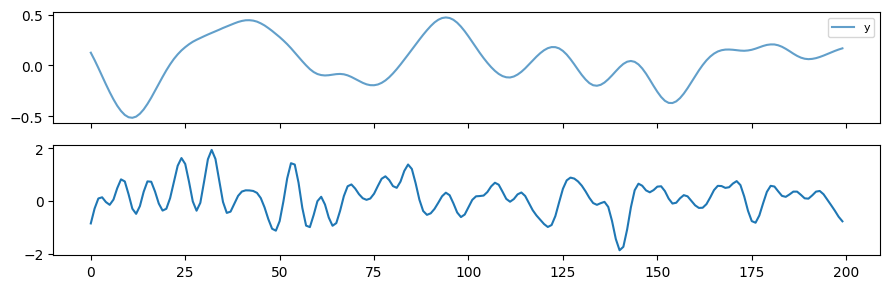

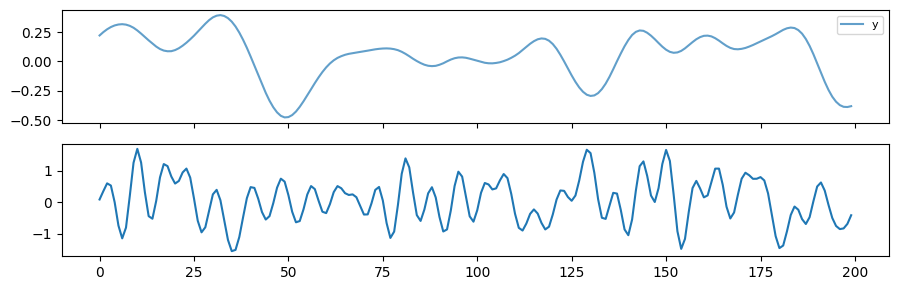

In [3]:
dls_standard = create_dls(
    u=['u'], y=['y'],
    dataset=data_path,
    win_sz=200, stp_sz=50,
    bs=32,
)
dls_standard.show_batch(max_n=2)

## Building a Custom Pipeline Step by Step

Now let's rebuild the same pipeline manually to understand each component.
This knowledge lets you customize any part of the pipeline when the standard
approach doesn't fit your needs.

### Step 1: Create Window Definitions

`CreateDict` takes a list of file paths and produces a list of dictionaries,
one per training sample. By passing `DfHDFCreateWindows`, each file is split
into overlapping windows. By passing `ValidClmContains`, a `valid` column is
added to mark validation and test files.

Parameters for `DfHDFCreateWindows`:

- **`win_sz=200`** -- the length of each window in time steps.
- **`stp_sz=50`** -- the stride between consecutive windows.
- **`clm='u'`** -- which HDF5 dataset to read for determining sequence
  length. The function reads this dataset's shape to calculate how many
  windows fit in the file.

In [4]:
items = CreateDict([
    DfHDFCreateWindows(win_sz=200, stp_sz=50, clm='u'),
    ValidClmContains(['valid', 'test']),
])(files)

print(f"Total windows: {len(items)}")
print(f"First item keys: {list(items[0].keys())}")
print(f"First item: {items[0]}")

Total windows: 3751
First item keys: ['path', 'l_slc', 'r_slc', 'valid']
First item: {'path': '/home/pheenix/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5', 'l_slc': 0, 'r_slc': 200, 'valid': True}


Each item is a dictionary with:

- **`path`** -- full file path to the HDF5 file.
- **`l_slc`** / **`r_slc`** -- left and right slice boundaries defining the
  window within the file.
- **`valid`** -- `True` for files whose path contains `"valid"` or `"test"`,
  used for train/validation splitting.

### Step 2: Build a DataBlock

The `DataBlock` ties together all the pieces: how to get items, how to split
them, and how to extract tensors. `SequenceBlock.from_hdf` creates a
`TransformBlock` that reads columns from HDF5 files and converts them to
typed tensors.

- **`blocks`** -- a tuple of `TransformBlock` objects defining input and
  output types. The first block extracts input signals (`'u'`), the second
  extracts output signals (`'y'`). Note that the output block uses
  `TensorSequencesOutput` to distinguish it from inputs.
- **`splitter`** -- determines how items are split into training and
  validation sets. `ParentSplitter()` splits by parent directory name: files
  in `train/` go to training, files in `valid/` go to validation.
- **`get_items`** -- a callable that takes the source (file list) and returns
  a list of items (dictionaries with window definitions).

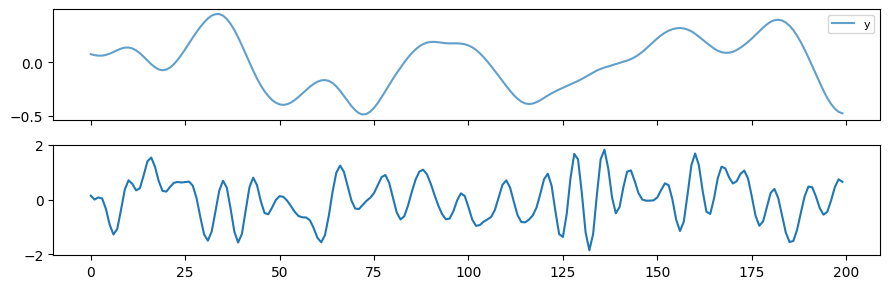

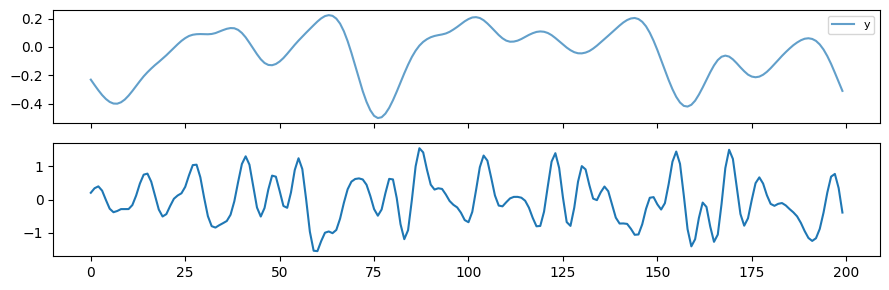

In [5]:
dblock = DataBlock(
    blocks=(
        SequenceBlock.from_hdf(['u']),
        SequenceBlock.from_hdf(['y'], seq_cls=TensorSequencesOutput),
    ),
    splitter=ParentSplitter(),
    get_items=CreateDict([DfHDFCreateWindows(win_sz=200, stp_sz=50, clm='u')]),
)

dls_custom = dblock.dataloaders(files, bs=32)
dls_custom.show_batch(max_n=2)

## Fixed Batch Counts with NBatches_Factory

When datasets have very different sizes, you may want a fixed number of
batches per epoch regardless of how many windows exist. `NBatches_Factory`
wraps a DataLoader class so it always yields exactly `n_batches` batches:
it oversamples (with replacement) when there are fewer samples than needed,
and undersamples when there are more.

This is useful for:

- **Consistent training time** across datasets of varying size.
- **Curriculum learning** where you want to control exposure per epoch.
- **Balancing** when combining datasets of different lengths.

In [6]:
dls_nbatch = dblock.dataloaders(
    files, bs=32,
    dl_type=NBatches_Factory(dls_custom.train.__class__),
    dl_kwargs=[{'n_batches': 100}, {'n_batches': None}],
)
print(f"Training batches per epoch: {len(dls_nbatch.train)}")
print(f"Validation batches per epoch: {len(dls_nbatch.valid)}")

Training batches per epoch: 100
Validation batches per epoch: 13


## Variable-Length Sequences with Padding

When HDF5 files have different lengths and you want windows that cover the
full file without overlap, the resulting sequences may vary in length across
files. Setting `padding=True` on `SequenceBlock.from_hdf` adds a collation
function that pads shorter sequences with zeros to match the longest sequence
in each batch.

This is useful when:

- Files represent separate experiments of varying duration.
- You want to process each file as a single window (no sub-windowing).
- You need batch processing but your sequences have different lengths.

In [7]:
dblock_padded = DataBlock(
    blocks=(
        SequenceBlock.from_hdf(['u'], padding=True),
        SequenceBlock.from_hdf(['y'], seq_cls=TensorSequencesOutput, padding=True),
    ),
    splitter=ParentSplitter(),
    get_items=CreateDict([DfHDFCreateWindows(win_sz=200, stp_sz=200, clm='u')]),
)

## Training with the Custom Pipeline

Let's train an LSTM on the custom DataLoaders to verify everything works
end-to-end. `RNNLearner` creates a recurrent neural network wrapped in a
fastai Learner.

Parameters:

- **`dls_custom`** -- the DataLoaders we built manually above.
- **`rnn_type='lstm'`** -- use Long Short-Term Memory cells.
- **`hidden_size=40`** -- number of hidden units in the LSTM.
- **`metrics=[fun_rmse]`** -- track root mean squared error during training.

In [8]:
lrn = RNNLearner(dls_custom, rnn_type='lstm', hidden_size=40, metrics=[fun_rmse])
lrn.fit_flat_cos(n_epoch=5, lr=3e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.140161,0.072352,0.103477,00:01
1,0.071835,0.037545,0.070690,00:01
2,0.045167,0.030374,0.067686,00:01
3,0.034979,0.032888,0.067987,00:01
4,0.029998,0.027732,0.066647,00:01


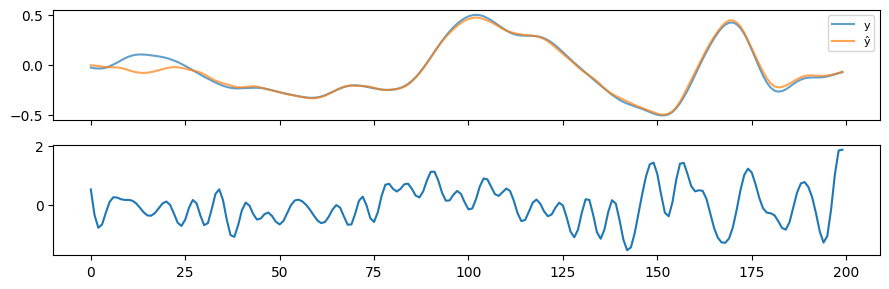

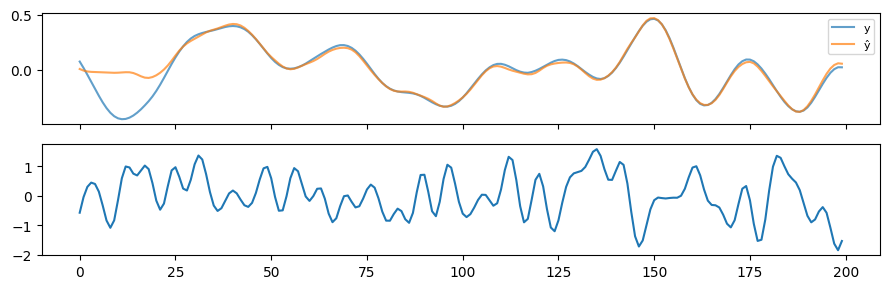

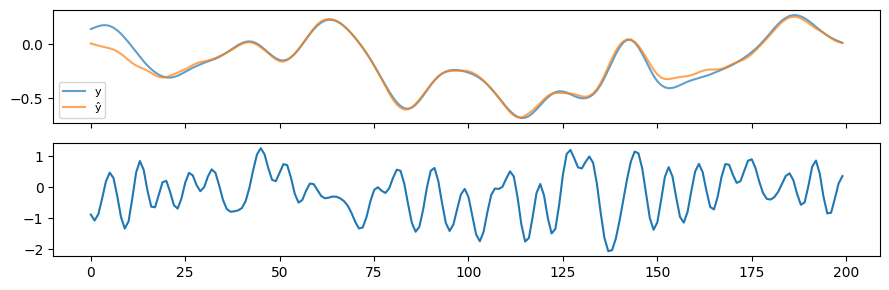

In [9]:
lrn.show_results(max_n=3)

## Key Takeaways

- **`get_hdf_files`** discovers HDF5 files recursively in a directory tree.
- **`CreateDict`** + **`DfHDFCreateWindows`** creates window definitions from
  file paths, where each item is a dictionary with file path and slice
  boundaries.
- **`ValidClmContains`** marks validation files by checking whether the file
  path contains specific strings (e.g., `"valid"`, `"test"`).
- **`DataBlock`** with **`SequenceBlock.from_hdf`** creates flexible
  input/output pipelines that read directly from HDF5 files.
- **`ParentSplitter`** splits data into train/validation sets based on parent
  directory names (e.g., `train/` vs `valid/`).
- **`NBatches_Factory`** ensures a fixed number of batches per epoch
  regardless of dataset size.
- **`padding=True`** handles variable-length sequences by zero-padding within
  each batch.
- The standard **`create_dls`** composes these same primitives internally --
  understanding them lets you customize any part of the pipeline.